In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [23]:
# อ่านไฟล์ CSV
file_path = 'sit-stand-walk-sleep.csv'  # กำหนดไฟล์ CSV
df = pd.read_csv(file_path)  # อ่านข้อมูลจากไฟล์ CSV

# แสดง DataFrame ในรูปแบบตาราง
df

,frames,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,0,758,395,-0.181572,765,384,-0.168180,769,384,-0.168174,...,-0.148523,740,848,-0.185707,885,867,-0.238619,712,891,-0.280369
1,1,758,394,-0.147162,764,382,-0.132827,769,383,-0.132832,...,-0.207323,739,850,-0.219445,885,867,-0.308259,712,890,-0.323930
2,2,757,394,-0.139463,764,382,-0.124957,769,383,-0.124962,...,-0.212225,738,851,-0.225214,885,868,-0.312419,712,889,-0.329420
3,3,757,394,-0.133706,763,382,-0.119350,768,383,-0.119354,...,-0.208859,738,852,-0.225732,886,868,-0.307024,712,889,-0.328685
4,4,757,394,-0.140752,763,382,-0.126483,768,383,-0.126486,...,-0.211440,738,854,-0.228110,886,869,-0.310501,712,889,-0.332102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,1136,675,845,0.042404,660,844,0.017827,660,846,0.017841,...,0.005329,1329,723,0.226227,1380,846,-0.029182,1335,796,0.212427
1137,1137,675,844,0.042922,660,844,0.018342,660,845,0.018350,...,0.005845,1329,722,0.221498,1378,846,-0.028058,1335,795,0.210955
1138,1138,675,844,0.043293,660,843,0.018902,660,845,0.018904,...,0.005228,1329,722,0.206703,1377,846,-0.028276,1335,795,0.194711
1139,1139,675,844,0.044549,660,843,0.021110,660,845,0.021111,...,-0.033934,1330,722,0.190985,1377,846,-0.073279,1336,796,0.176809


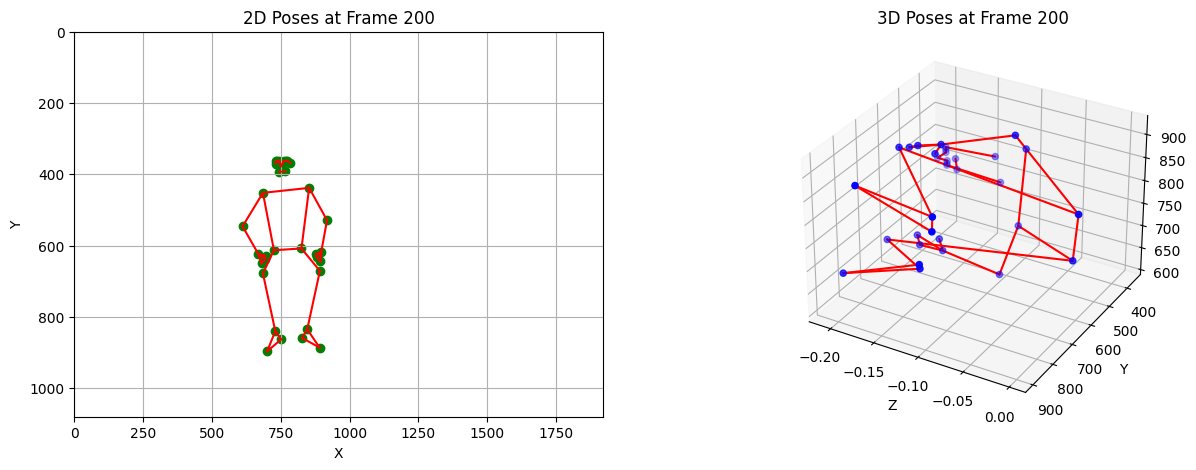

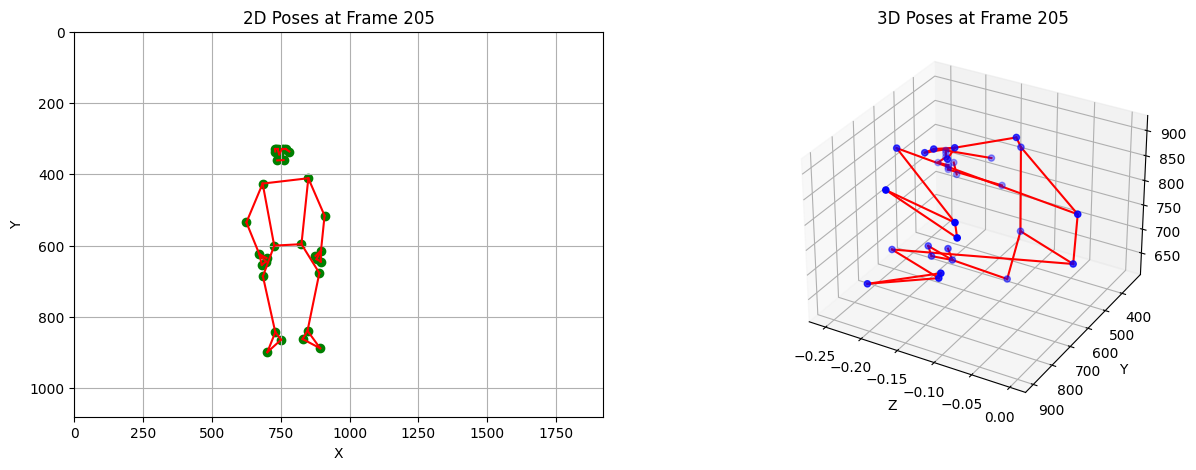

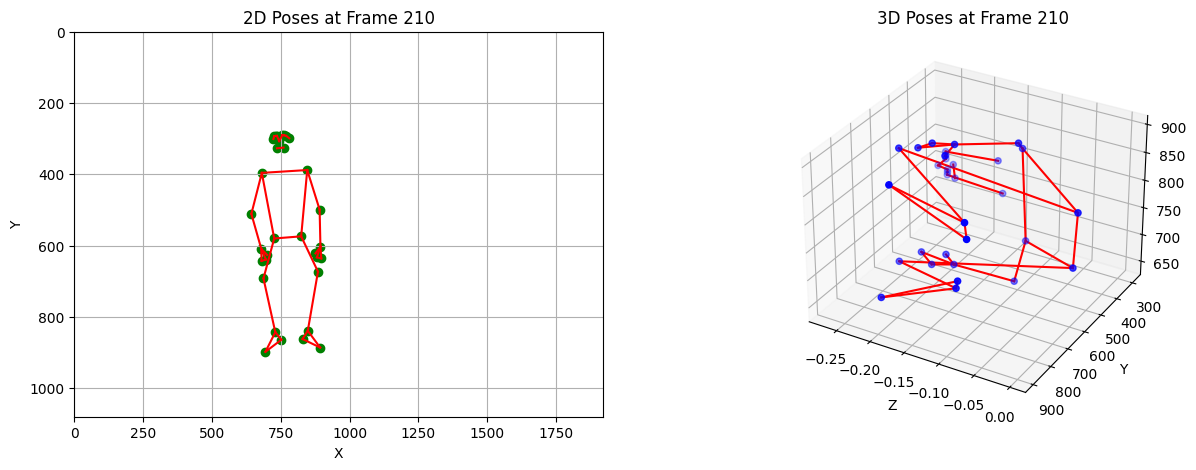

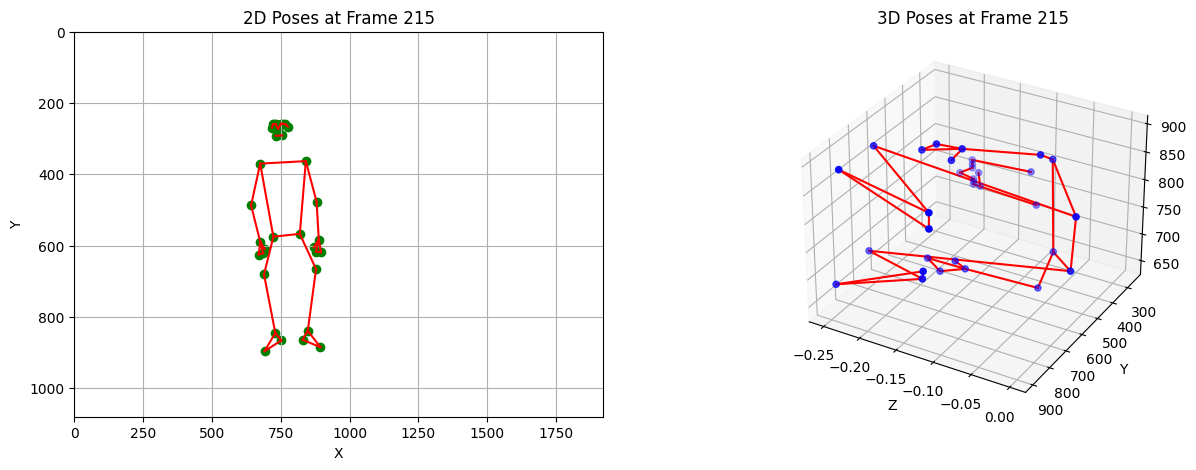

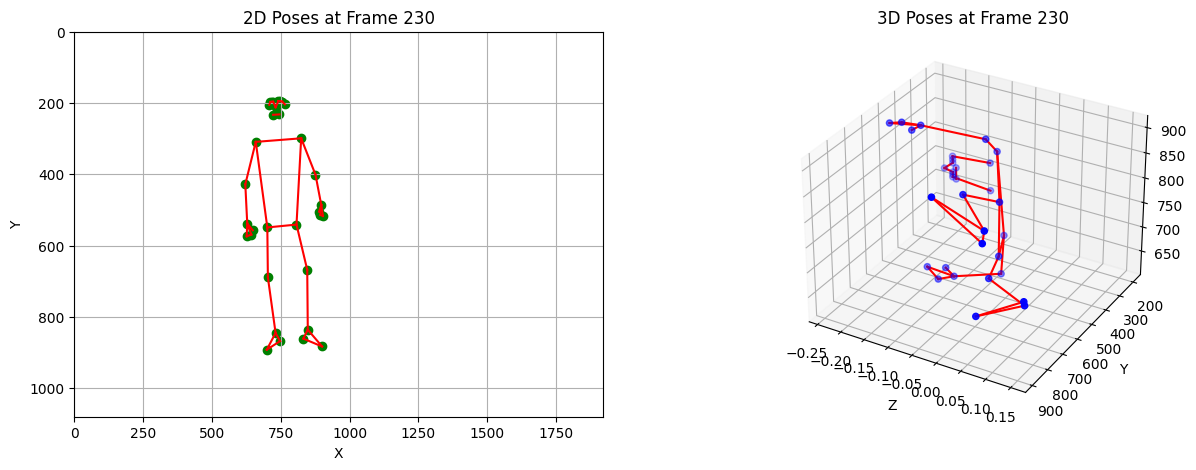

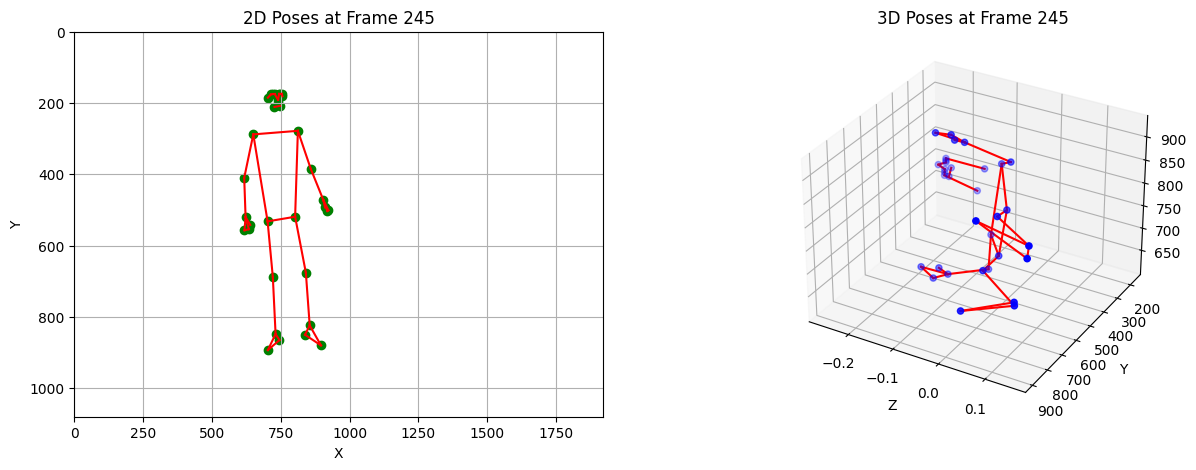

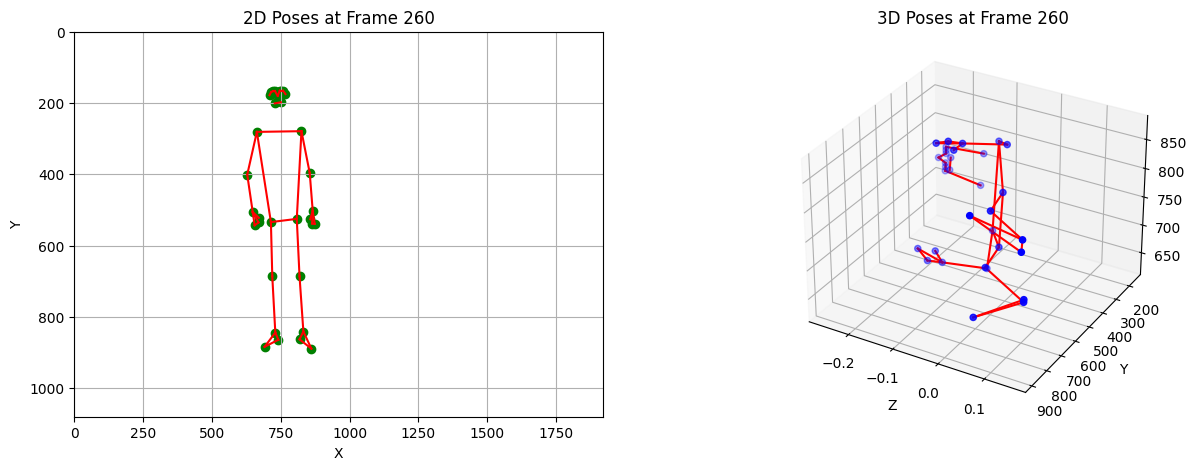

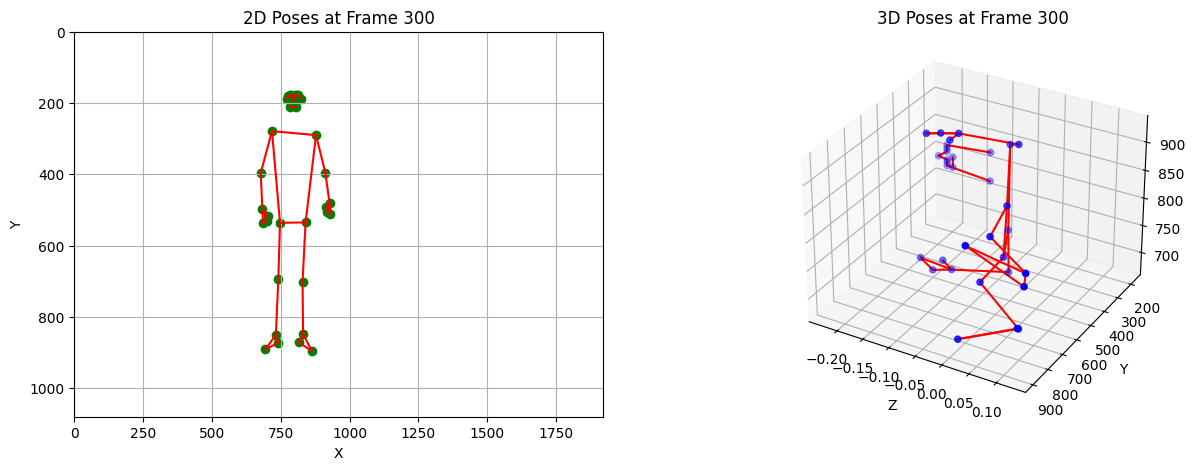

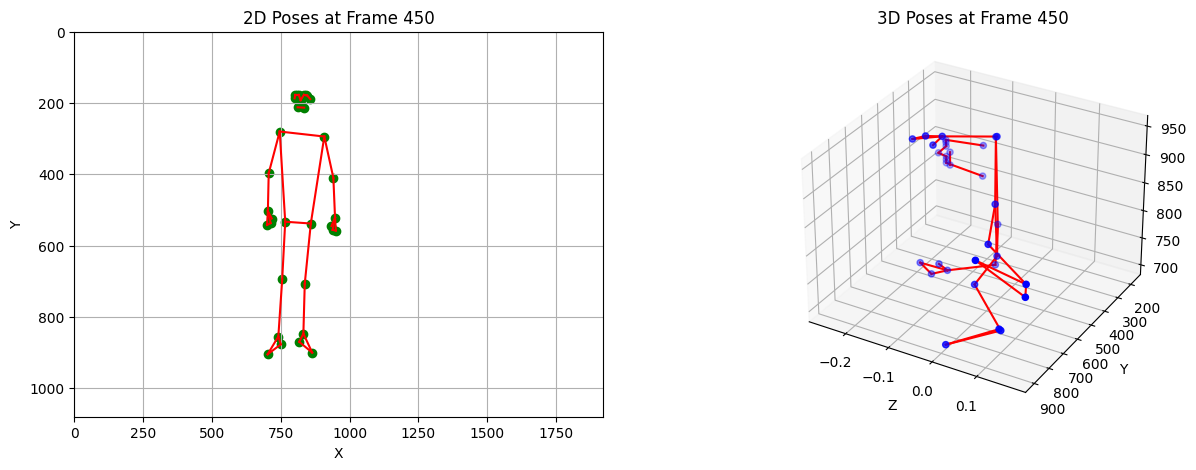

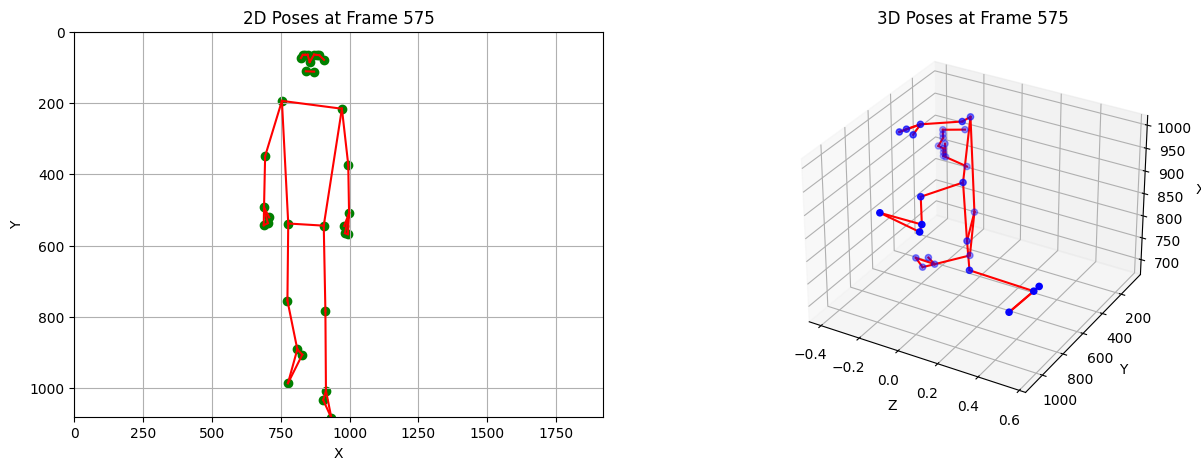

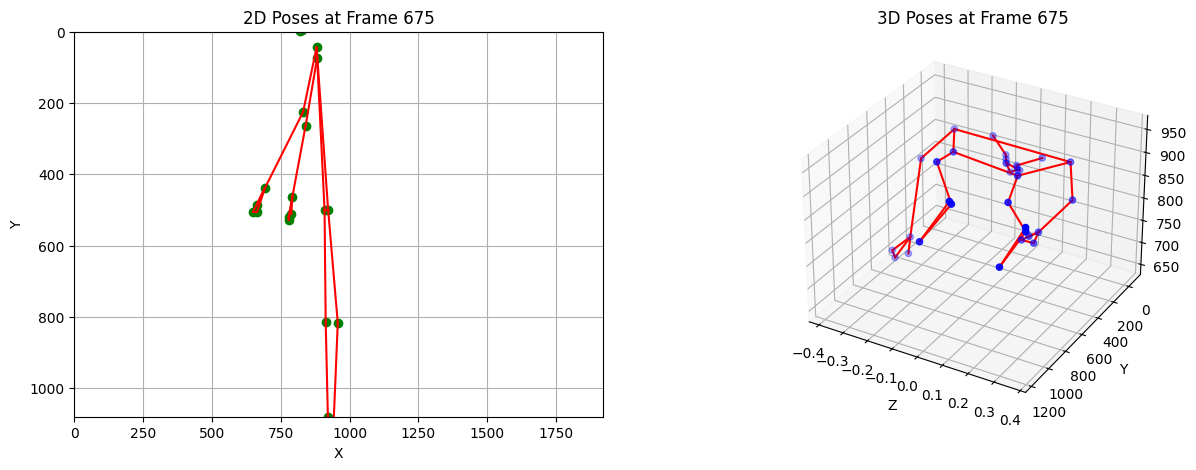

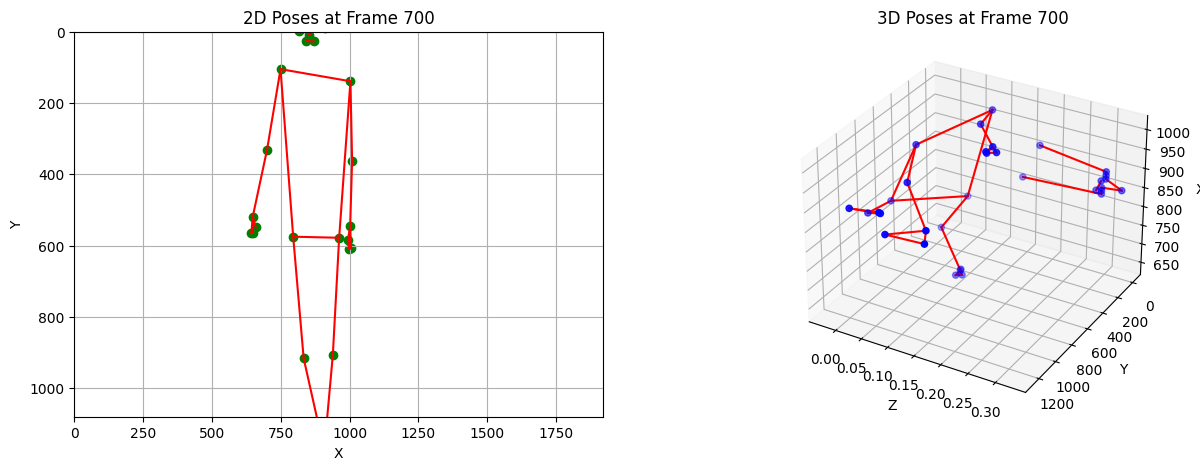

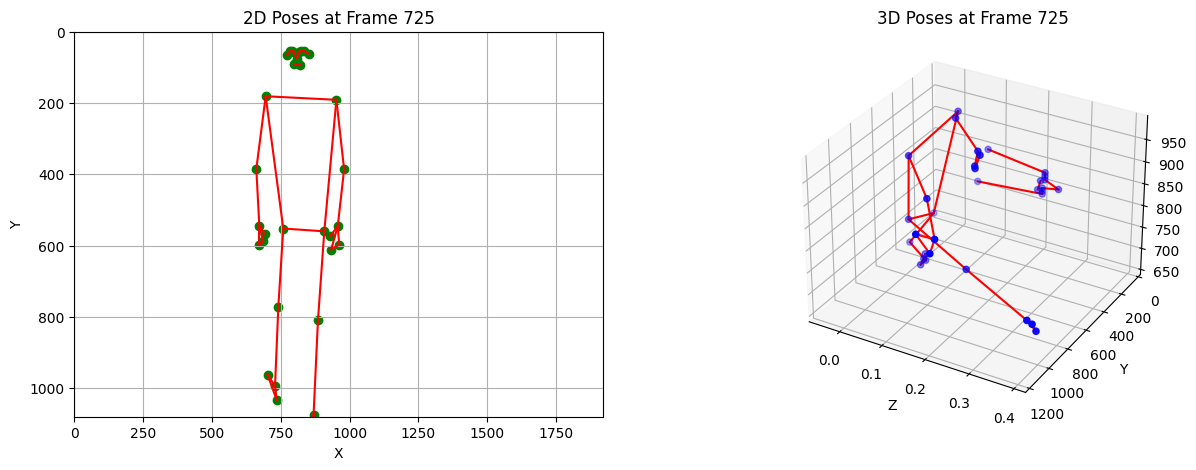

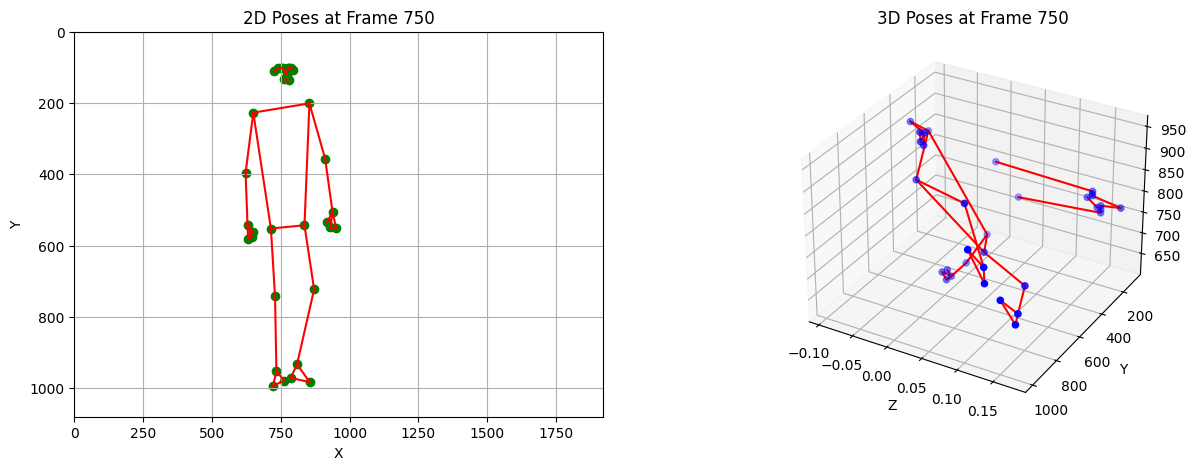

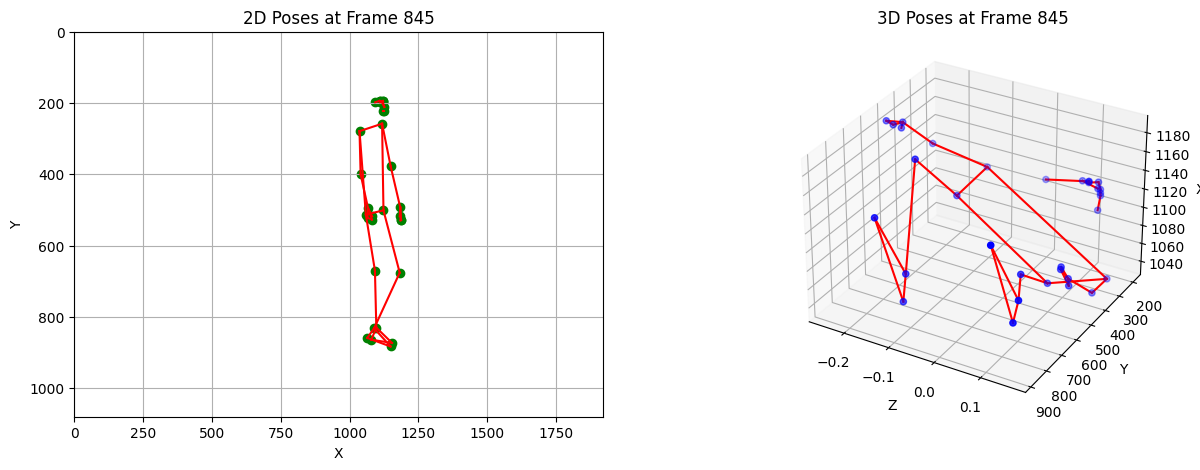

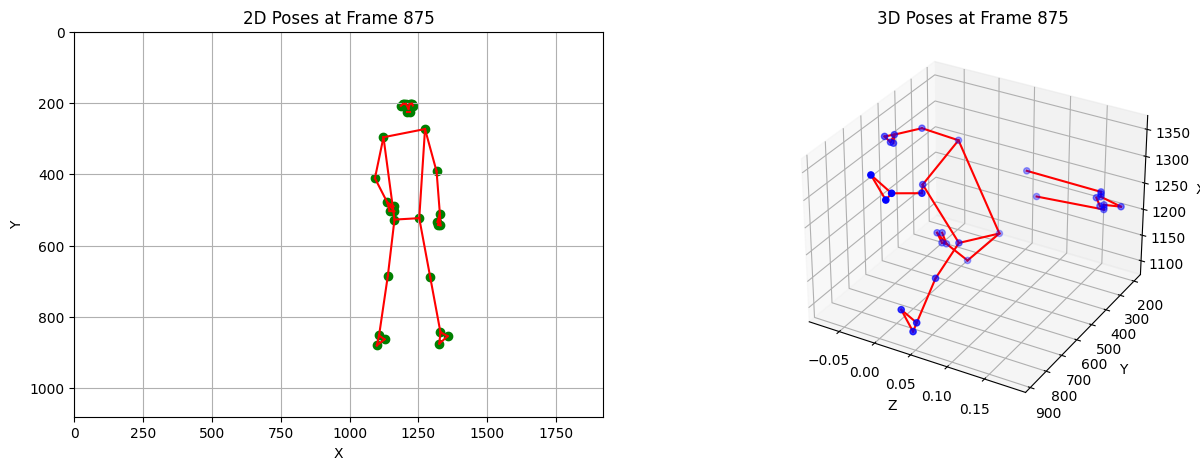

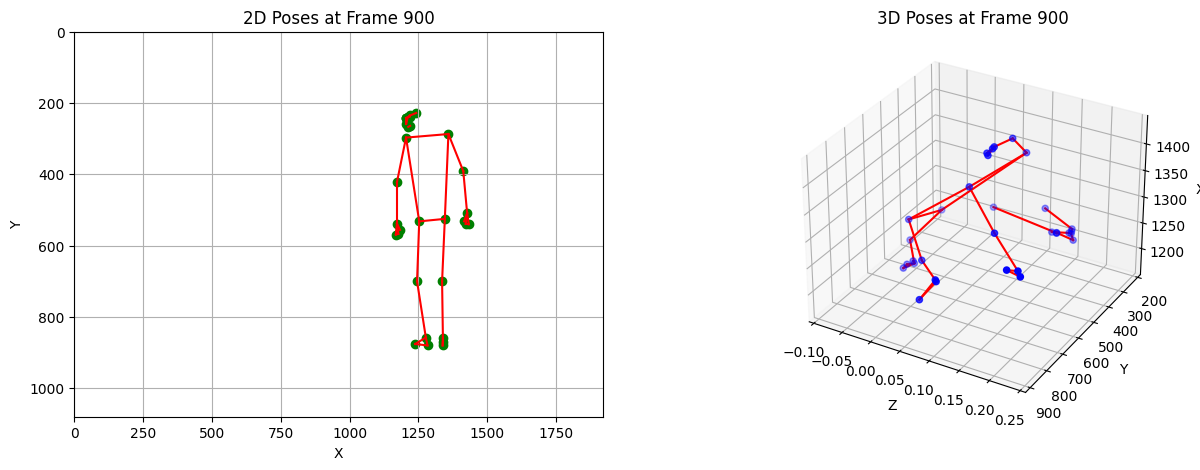

In [24]:
# ฟังก์ชันสำหรับการสร้าง skeleton พร้อม grid
def plot_skeleton(frame_data, frame_number):
    # กำหนดจุด landmark ที่จะเชื่อมต่อกัน
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), (9, 10),  # หัว
        (11, 12), (12, 24), (24, 23), (23, 11),  # ลำตัว
        (11, 13), (13, 15), (12, 14), (14, 16), # แขน
        (15, 17), (15, 21), (15, 19), (19, 17), # มือซ้าย
        (16, 18), (16, 22), (16, 20), (20, 18), # มือขวา
        (23, 25), (25, 27), (27, 29), (29, 31), (31, 27),  # ขาขวา
        (24, 26), (26, 28), (28, 30), (30, 32), (28, 32)  # ขาซ้าย
    ]
    
    # ดึงค่าข้อมูล x และ y สำหรับแต่ละ landmark
    x_vals = [frame_data[f'x{i}'] for i in range(33)]
    y_vals = [frame_data[f'y{i}'] for i in range(33)]
    z_vals = [frame_data[f'z{i}'] for i in range(33)]
    
    # สร้างภาพแบบ subplot ที่มี 2D และ 3D
    fig = plt.figure(figsize=(15, 5))
    
    # วาด 2D skeleton ใน subplot แรก
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(f'2D Poses at Frame {frame_number}')
    ax1.scatter(x_vals, y_vals, c='green')  # วาดจุด
    for conn in connections:
        ax1.plot([x_vals[conn[0]], x_vals[conn[1]]], [y_vals[conn[0]], y_vals[conn[1]]], 'r-')  # วาดเส้นเชื่อมต่อ
    ax1.grid(True)  # เปิดกริด
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    # กำหนดขนาดสูงสุดของแกน
    ax1.set_xlim(0, 1920)  # ตั้งค่าขนาดแกน x
    ax1.set_ylim(1080, 0)  # ตั้งค่าขนาดแกน y

    # ************************************** กำลังแก้
    # วาด 3D skeleton ใน subplot ที่สอง
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f'3D Poses at Frame {frame_number}')
    
    # ******* ตรงนี้ต้องกลับมาดูใหม่
    # ลำดับค่าพิกัด: 1 เป็นความลึก, 2 เป็นความสูง (invert), 3 เป็นแนวกว้าง
    ax2.scatter(z_vals, y_vals, x_vals, c='blue')  # วาดจุด

    for conn in connections:
        ax2.plot([z_vals[conn[0]], z_vals[conn[1]]],  
                 [y_vals[conn[0]], y_vals[conn[1]]],  
                 [x_vals[conn[0]], x_vals[conn[1]]], 'r-') 
    
    ax2.set_xlabel('Z')  
    ax2.set_ylabel('Y')  
    ax2.set_zlabel('X') 
    ax2.invert_yaxis()  # ให้แกน Y invert
    ax2.grid(True)  # เปิดกริด

    plt.show()

# แสดง skeleton สำหรับเฟรมที่เลือก
selected_frames = [200, 205, 210, 215, 230, 245, 260, 300, 450, 575, 675, 700, 725, 750, 845, 875, 900]

# แสดง skeleton
for frame in selected_frames:
    frame_data = df[df['frames'] == frame].iloc[0]
    plot_skeleton(frame_data, frame)